### The Dataset is stored in the ```dataset``` folder 
downloaded from ```http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip```
### The GloVe vector embeddings are in the ```glove``` folder 
downloaded from ```https://github.com/stanfordnlp/GloVe```
### The Counter-Fitted vectors are in the ```counter-fitted``` folder
download from ```https://github.com/nmrksic/counter-fitting/blob/master/word_vectors/counter-fitted-vectors.txt.zip```
(see referenced paper [20])


# Import dependecies 
Start by importing all the required libraries

In [1]:
"""
Python 3.8.5
Tensorflow 2.2.0
Keras 2.4.3

wordcloud 1.8.0
"""
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import string # use this to remove punctuation from tweets e.g. string.punctuation
import random as rnd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pickle
import os
import re
from keras.preprocessing.text import Tokenizer

############ CONSTANTS ##################################

# DATA FILE LOCATIONS
DATA_SET = "dataset/train.csv"
COUNTER_FITTED_vectors = "counter-fitted/counter-fitted-vectors.txt" 
GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"

# DATA SPLIT & VOCABULARY SIZE
TRAINING_SPLIT = 0.8
MAXIMUM_VOCABULARY = 50000
MAX_TEXT_LENGTH = 40

In [2]:
print(STOPWORDS)

{'such', 'we', 'were', 'this', 'had', "they're", "weren't", "i'd", 'only', 'once', 'his', 'itself', 'your', "there's", 'also', 'by', 'should', 'then', "you've", 'so', 'too', 'whom', 'out', 'about', 'else', 'over', "we'll", 'yourself', 'own', 'since', 'ought', 'after', 'like', 'any', 'than', 'if', 'therefore', 'few', 'under', 'a', 'am', 'does', "he's", 'k', "mustn't", 'most', 'on', 'all', "hasn't", 'could', 'himself', 'here', 'through', 'which', "i've", "who's", 'him', 'until', "won't", "he'll", "what's", 'yours', 'ours', "let's", 'the', 'who', 'its', 'each', 'they', "isn't", "i'll", 'an', "it's", 'ever', 'them', 'otherwise', 'cannot', 'not', "can't", "they'll", 'again', "shan't", 'during', 'r', 'shall', "shouldn't", 'just', 'my', "i'm", 'she', 'hence', 'having', 'there', 'what', 'at', 'that', 'would', 'theirs', "you'd", "hadn't", "that's", 'myself', "don't", 'have', 'http', 'me', 'before', "couldn't", "we've", 'get', 'same', 'into', 'hers', 'against', "haven't", 'you', 'further', 'with

# Process dataset
### Read the dataset file and return a data frame


In [3]:
def process_dataset_Sentiment140(file_path: str ):
    # load the data file into a data frame
    df = pd.read_csv(file_path, encoding='latin-1', header=None) # changed encoding to 'latin-1'
    
    # Rename the columns so we can reference them later
    df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
    
    # drop all the columns we don't need
    df = df.drop(['id', 'date', 'query', 'user_id'], axis=1) 
    
    # change all 4's to 1's (just for neatness)
    df.loc[df['sentiment'] == 4, 'sentiment'] = 1
    
    # sort all the rows by the sentiment columns
    df.sort_values(by=['sentiment'])
    
    return df
    

### Read in the dataset file and show the first 5 rows of the data frame


In [4]:
data_frame = process_dataset_Sentiment140(DATA_SET)
data_frame.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Plot the data
#### We see that we have 2 types of sentiments, ```0 = negative``` and ```1 = positive```. We have 800,000 data points for each type of sentiment

Text(0.5, 1.0, 'Sentiment Distribution')

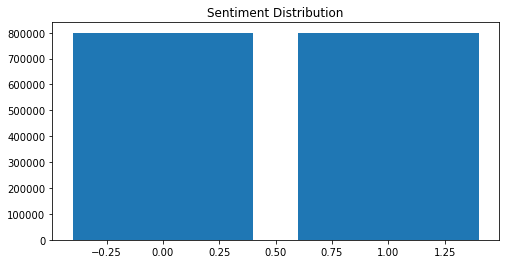

In [5]:
val_count = data_frame.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Distribution")

### We need to remove hyperlinks from the text - define a regex here to use

In [6]:

"""
preprocess-twitter.py

Script for preprocessing tweets by Romain Paulus

Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb

this version from gist.github.com/ppope > preprocess_twitter.py

Extended by Manjinder Singh, to enable removal of html entities, and punctuation symbols (except the apostophe)
"""
FLAGS = re.MULTILINE | re.DOTALL

# html entities to remove
html_entities = [" quot ", " amp ", " lt ", " gt ", " circ ", " tilde ", " ensp ", " emsp ", " thinsp ", " zwnj ", " zwj ", 
                     " lrm ", " rlm ", " ndash ", " mdash ", " lsquo ", " rsquo ", " sbquo ", " ldquo ", " rdquo ", " bdquo ", " permil ", " lsaquo ", " rsaquo "]

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body.lower())
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return  result

def allcaps(text):
    text = text.group()
    return text.lower() # removed tag


def tokenize(text):
    
    punctuation = string.punctuation
    punctuation = punctuation.translate({ord(i):None for i in "'"}) # keep the apostrophe
       
    # lower case all text
    text = text.lower()
    # remove extra spaces so we can then remove all amp and quot chars correctly, also removes trailing spaces
    text = ' '.join(text.split()) 
    
    
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "") # url
    text = re_sub(r"@\w+", "") # twitter username
    text = re_sub(r"&\w+", "") # remove html entities starting with a &
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "") # smile
    text = re_sub(r"{}{}p+".format(eyes, nose), "") # lolface
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "") # sadface
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "") # neutralface
    text = re_sub(r"/"," / ")
    text = re_sub(r"<3","") # heart
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "") # remove numbers
    text = re_sub(r"#\w+", "")  # remove hashtag
    text = re_sub(r"([!?.]){2,}", r"\1 ") # remove punctuation repetitions eg. "!!!" 
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 ") # remove elongated words and trim eg. shorten 'Awwwwwwwww' to 'Aw'
    

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    #text = re_sub(r"([A-Z]){2,}", allcaps)  # moved below -amackcrane

    # amackcrane additions
    text = re_sub(r"([a-zA-Z<>()])([?!.:;,])", r"\1 \2")
    text = re_sub(r"\(([a-zA-Z<>]+)\)", r"( \1 )")
    text = re_sub(r"  ", r" ")
    #text = re_sub(r" ([A-Z]){2,} ", allcaps) # lowercase all caps
    
    
    # finally remove all punctuation and numbers
    text  = "".join([char for char in text if char not in punctuation])
    text = re.sub('[0-9]+', '', text)
    
    # remove all html entities
    for h in html_entities:
        if h in text:
            text = re_sub(h, "")
    

    return text.lower()


# decided to use this regex instead of the above script
# we are using the glove 300d embeddings rather than the twitter glove embeddings

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"




### Use the regex to clean all our text entries and write back to the data frame

In [7]:

# punctuation = string.punctuation
# punctuation = punctuation.translate({ord(i):None for i in "'"})
# print(punctuation)

def clean_text(text, stem=False):
    
    text  = "".join([char for char in text if char not in punctuation])
    
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    
    #text = re.sub('[0-9]+', '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"https\S+", "", text)
    text = re.sub(r"&amp\S+", "", text)
    text = re.sub(r" amp ", "", text)
    text = re.sub(r" quot ", "", text)
    return text

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [8]:

data_frame.text = data_frame.text.apply(lambda x: tokenize(x))

# save the cleaned dataset
data_frame.to_csv("dataset/clean_data.csv", index = False)

In [9]:
# clean data file
data_frame.head()

,sentiment,text
0,0,aw that's a bummer you shoulda got david c...
1,0,is upset that he can't update his facebook by ...
2,0,i dived many times for the ball managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,no it's not behaving at all i'm mad why am...


# Wordcloud of ```positive``` sentiments

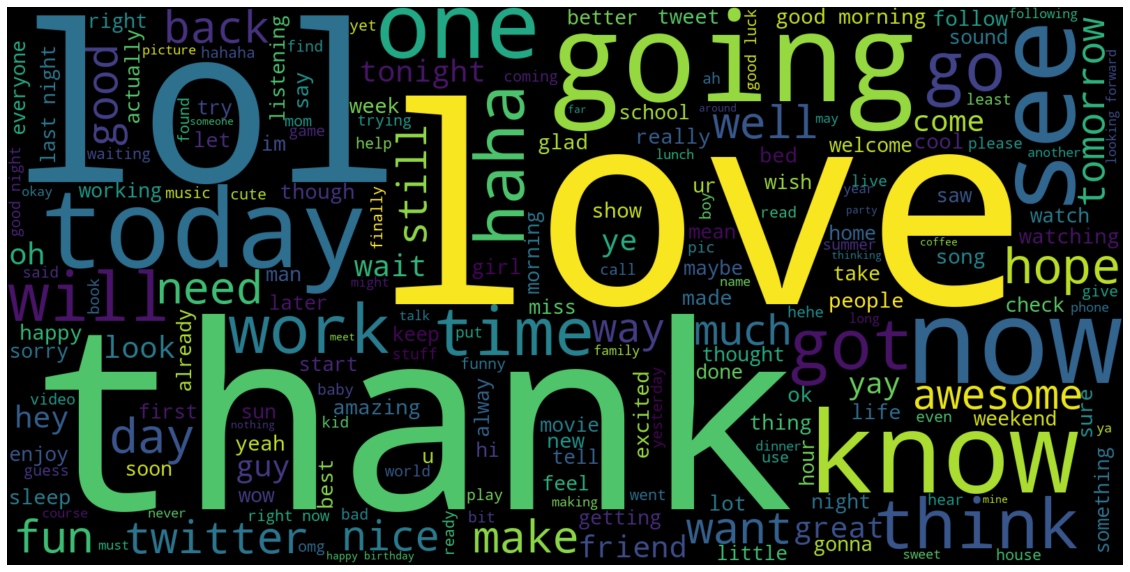

In [10]:


plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

# Wordcloud of ```negative``` sentiments

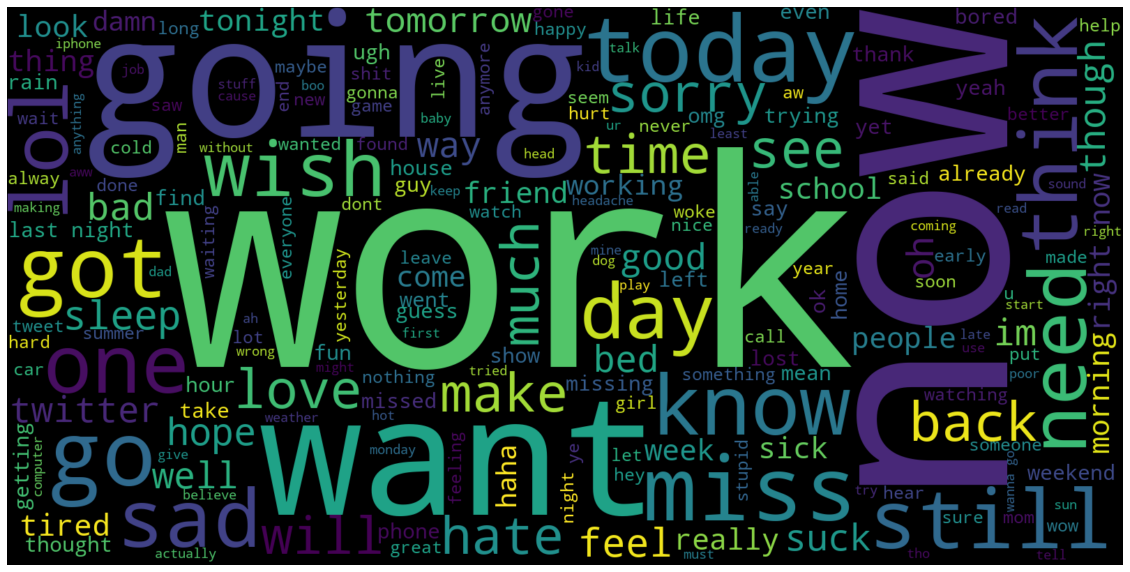

In [11]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(stopwords = STOPWORDS, width = 1600 , height = 800).generate(" ".join(data_frame[data_frame.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Now we need randomise the dataset

In [12]:
data_frame = data_frame.sample(frac = 1, random_state = 7) # frac = 1 i.e. the entire data frame, random_state = Seed for the random number generator 

In [13]:
data_frame.head()

,sentiment,text
709290,0,feelin down lately but i've no reason too
654075,0,with ju clare elly and zoe about to leave ma...
728623,0,wish i couldve seen miley and nick sing night
697650,0,had to work today hour down to go
1244425,1,just started to catch up on house viewing kin...


### Now we split the data set into 80% for training and 20% for testing
#### This will also shuffle the data set before splitting it

In [14]:
train_size, test_size = train_test_split(data_frame, test_size= (1 - TRAINING_SPLIT), random_state = 7)

In [15]:
print("Training Data:\t",len(train_size), " data points")
print("Test Data:\t",len(test_size), " data points")

Training Data:	 1280000  data points
Test Data:	 320000  data points


### Examine the training and test data sets

#### Training dataset

In [16]:
train_size.head()

,sentiment,text
891695,1,is loving his new table from ikea which he got...
976601,1,you got this can't wait to here some new fro...
17324,0,heh actually getting pretty sleepeh so i'm ...
775910,0,cleaning the kitchen
401516,0,waiting for a wii system update to finish fee...


#### Testing dataset

In [17]:
test_size.head()

,sentiment,text
1427435,1,i wish or i would be buying or lol you'd ma...
1101080,1,i hate you right now
1085676,1,up to no good as always
1025165,1,means so much chris thanks
760122,0,winter classes early empire pop culture peop...




# Tokenization of training data
- We will use the TensorFlow (Keras) Tokenizer class to tokenize our training data (see imports above)
- We define some hyperparameters we will use when performing tokenization
- First we create the Tokenizer object as well as an out of vocabulary token (oov_token) to use for encoding test data words we have not come across in our training, if we don't do this then previously-unseen words would never be unaccounted for. 
- After the Tokenizer has been created, we then fit it on the training data (we do the same for our test dataset).

<center>
<img src="images/tokenization-manning.png">
</center>



    
<center><strong>Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.</strong></center>
    


In [18]:
# hyper parameters provided to tokenizer

"""
the UNK token which will be used for out of vocabulary tokens encountered during the 
tokenizing and encoding of the test data sequences created using the word index built during 
tokenization of our training data.
"""
oov_token = '<UNK>'


"""
When we are encoding our numeric sequence representations of the text data, our tweet
string lengths will be of different lengths and so we will need to select a maximum length 
for tweets and pad shorter tweets with a padding character.

We will first calculate the size of the largest tweet string, and then use '0' as a padding character, to pad out shorter
tweets. This ensures all our sequenes of text are of the same length.

Here are specifying that we want the padding at the end of the sequence of tokens
"""
pad_type = 'post'



In [19]:
# Tokenize training data 
tokenizer = Tokenizer(oov_token=oov_token)

# fit to our training dataset
tokenizer.fit_on_texts(train_size.text)


# store the training datas word_index
"""
The okenization process also creates a word index. This  maps words in our 
vocabulary to their numeric representation.

This mapping is then used to encoding our sequences. 
"""
word_index = tokenizer.word_index



# Encode the training tweet sentence into sequences
"""
After tokenizing our training data we have a word-to-numeric 
mapping of our vocabulary, this is used to encode our sequences. 

Here, we are converting our text sentences from something  like 
"the cat sat on the mat" to something like "3 6 7 2 1 4" where each of 
these numbers matches to the index of the corresponding words. 

Since Neural Networks work erforming computation on numbers, 
passing in set of strings will not work. Which is why we need these sequences.

So far, this is only the training dataset, the test dataset has to be
tokenized and encoded after we have competed the training dataset.
"""
train_sequences = tokenizer.texts_to_sequences(train_size.text)

# Get max training sequence length and double it (in case our training
# dataset has a longer sequence - we don't want it truncated)
"""
To ensure that all our sequences are of the same length, we need to set the 
maxlen hyperparameter. Here we set it using the maximum length found in
our training dataset sequences.
"""
maxlen = max([len(x) for x in train_sequences]) * 2

# Pad the training sequences
"""
The encoded sequences need to be the same length. 

We use the maxlen found above to set this length. This will 
pad all other sequences with extra '0's at the end ('post').
"""
train_padded = pad_sequences(train_sequences, padding=pad_type, maxlen=maxlen)



# vocab_size = len(tokenizer.word_index) + 1
# dataset_size = tokenizer.document_count



# Check results of tokenization and creation of training sequences

In [20]:

print("Padded Training Shape:", train_padded.shape,"\n")
print("maxlen (maximum length of sequences):", maxlen,"\n")
# print("Word Index:", type(word_index),"\n")
# print("Training sequences data type:", type(train_sequences),"\n")
# print("Padded Training Sequences data type:", type(train_padded),"\n")


print("\nExample Training Sequences:\n",train_sequences[1])
print("\nExample Padded Training Sequences:\n",train_padded[0])


Padded Training Shape: (1280000, 90) 

maxlen (maximum length of sequences): 90 


Example Training Sequences:
 [8, 47, 27, 66, 135, 3, 85, 67, 74, 52, 277, 173, 13, 315]

Example Padded Training Sequences:
 [    9   677   184    74  1827    52  3657   386   106    47    12     4
 97680  2555    11    80    68  6204   244    79     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


# Tokenization of testing data
- We use the same tokenizer to tokenize the test dataset (similar to above)
- We use the same tokenizer to ensure we are using the same vocabulary. 
- We also pad to the same length (maxlen) as the training dataset

In [21]:
test_sequences = tokenizer.texts_to_sequences(test_size.text)
test_padded = pad_sequences(test_sequences, padding=pad_type, maxlen=maxlen)

In [22]:
print("Padded Testing Shape:", test_padded.shape,"\n")
print("maxlen (maximum length of sequences):", maxlen,"\n")

print("\nExample Testing sequences:\n",test_sequences[5])
print("\nExample Padded Testing Sequences:\n",test_padded[9])

# print the first entry only, to show the actual text as a padded sequqnce
for x, y in zip(test_size.text, test_padded):
    print("\n\n",'{} \n-> {}'.format(x, y))
    break

Padded Testing Shape: (320000, 90) 

maxlen (maximum length of sequences): 90 


Example Testing sequences:
 [96, 1425, 39, 595, 721]

Example Padded Testing Sequences:
 [    48    110  31608     48     25    110     48   3885   1186     48
    469     94      8      3  11985    362     48    795  10287    665
    110     22    301      1      1     29   3535    298 257965      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]


  i wish  or i would be buying or lol  you'd make a great father you should have one  
-> [   2  109  100    2  116   23 1328  100   48 1390  123    5   96 2089
    8  136   17   55    0  

### There are only two labels in our model
#### Extract the labels and store in a list called ```labels```

In [23]:
labels = train_size.sentiment.unique().tolist()
print(labels)

[1, 0]


#### Encode training labels using scikit-learn module sklearn.preprocessing.LabelEncoder

In [24]:
encoder = LabelEncoder()
encoder.fit(train_size.sentiment.to_list())

y_train = encoder.transform(train_size.sentiment.to_list())
y_test = encoder.transform(test_size.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


y_train shape: (1280000, 1)
y_test shape: (320000, 1)


# Word-Embeddings
#### Word embeddings is a feature vector for each of the words that enbales us to give words a ```context```.
- Instead of creating this ourselves, we will use a pre-trained embddings vectors (GloVe Embeddings)

# DATA FILE LOCATIONS
- DATA_SET = "dataset/train.csv"
- COUNTER_FITTED_vectors = "counter-fitted/counter-fitted-vectors.txt" 
- GLOVE_EMBEDDINGS = "glove/glove.840B.300d.txt"

In [25]:
DIMENSION = 300
LEARNING_RATE = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_SAVE_PATH = 'embeddings/'

# Load the word embeddings from the GloVe pre-trained model

In [32]:
MAX_VOCABULARY_SIZE = len(tokenizer.word_index) + 1

def create_glove_embeddings(g_file: str):
    
    
    dictionary = dict()
    dictionary['UNK'] = MAX_VOCABULARY_SIZE
    
    inv_dictionary = dict()
    inv_dictionary [MAX_VOCABULARY_SIZE] = 'UNK'
    
    embeddings_index = {}
    print("Opening and parsing file, please wait while we load embeddings ...")
    with open(g_file, 'r', encoding="utf8") as f:
        for line in f:
            row = line.strip().split(' ')
            word = row[0]
            embedding = np.array([float(val) for val in row[1:]])
            embeddings_index[word] = embedding
        print("Completed! Loaded ", len(embeddings_index), " words.")
        
    for word, w_index in tokenizer.word_index.items():
        if w_index < MAX_VOCABULARY_SIZE:
            
        
        
    return embeddings_index 

def create_glove_embeddings_matrix(glove_embeddings_index):
    embedding_matrix = np.zeros((VOCABULARY_SIZE, ))
    
    


In [30]:
embeddings_index = create_glove_embeddings(GLOVE_EMBEDDINGS)

Opening and parsing file, please wait while we load embeddings ...
Completed! Loaded  2196007  words.


In [34]:
print(MAX_VOCABULARY_SIZE)

261502
